In [1]:
!pip install scikit-learn pandas matplotlib seaborn --quiet
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

In [2]:
data = load_iris()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='target')
print("Original features:", list(X.columns))

Original features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In [3]:
def fisher_score(X_df, y_arr):
    scores = []
    classes = np.unique(y_arr)
    for col in X_df.columns:
        overall_mean = X_df[col].mean()
        num = den = 0
        for cls in classes:
            Xi = X_df[col][y_arr == cls]
            num += len(Xi) * (Xi.mean() - overall_mean) ** 2
            den += len(Xi) * Xi.var()
        scores.append(num / den if den else 0)
    return scores

fs = fisher_score(X, y)
fs_df = pd.DataFrame({'feature': X.columns, 'Fisher_score': fs}).sort_values(by='Fisher_score', ascending=False)
print(fs_df)

             feature  Fisher_score
2  petal length (cm)     15.735482
3   petal width (cm)     12.800095
0  sepal length (cm)      1.590193
1   sepal width (cm)      0.655467


In [4]:
from sklearn.feature_selection import SelectKBest, f_classif

anova_selector = SelectKBest(score_func=f_classif, k=X.shape[1])
anova_selector.fit(X, y)
df_anova = pd.DataFrame({
    'feature': X.columns,
    'F_score': anova_selector.scores_
}).sort_values(by='F_score', ascending=False)

# Merge Fisher and ANOVA scores for side-by-side comparison
df_compare = fs_df.merge(df_anova, on='feature')
print("Comparison of Fisher Scores and ANOVA F-scores:\n", df_compare)

# Correlation coefficient between Fisher and F-score
corr = df_compare['Fisher_score'].corr(df_compare['F_score'])
print(f"Correlation between Fisher score and ANOVA F-score: {corr:.3f}")

Comparison of Fisher Scores and ANOVA F-scores:
              feature  Fisher_score      F_score
0  petal length (cm)     15.735482  1180.161182
1   petal width (cm)     12.800095   960.007147
2  sepal length (cm)      1.590193   119.264502
3   sepal width (cm)      0.655467    49.160040
Correlation between Fisher score and ANOVA F-score: 1.000


ANOVA F-scores vs. Fisher scores:
              feature      F_score  Fisher_score
0  petal length (cm)  1180.161182     15.735482
1   petal width (cm)   960.007147     12.800095
2  sepal length (cm)   119.264502      1.590193
3   sepal width (cm)    49.160040      0.655467
Correlation between ANOVA F-score and Fisher score: 1.000


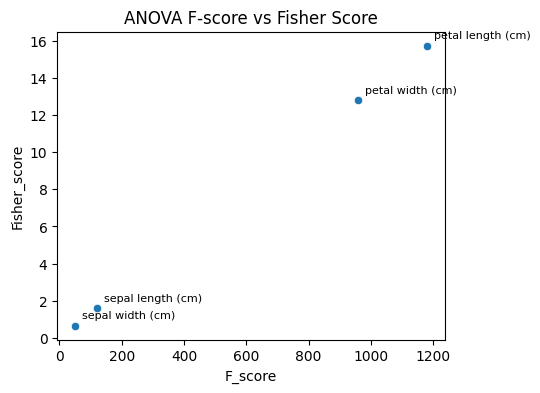

In [5]:
from sklearn.feature_selection import SelectKBest, f_classif

# Compute ANOVA F-scores for comparison
anova_selector = SelectKBest(score_func=f_classif, k=X.shape[1])
anova_selector.fit(X, y)
df_anova = pd.DataFrame({
    'feature': X.columns,
    'F_score': anova_selector.scores_
}).sort_values('F_score', ascending=False)

# Merge and display side by side
df_compare = df_anova.merge(fs_df, on='feature')
print("ANOVA F-scores vs. Fisher scores:\n", df_compare)

# Correlation between the two score sets
corr_coef = df_compare['F_score'].corr(df_compare['Fisher_score'])
print(f"Correlation between ANOVA F-score and Fisher score: {corr_coef:.3f}")

# Scatter plot to visualize relationship
plt.figure(figsize=(5,4))
sns.scatterplot(x='F_score', y='Fisher_score', data=df_compare)
plt.title('ANOVA F-score vs Fisher Score')
for i, row in df_compare.iterrows():
    plt.annotate(row['feature'], (row['F_score'], row['Fisher_score']),
                xytext=(5,5), textcoords='offset points', fontsize=8)
plt.show()

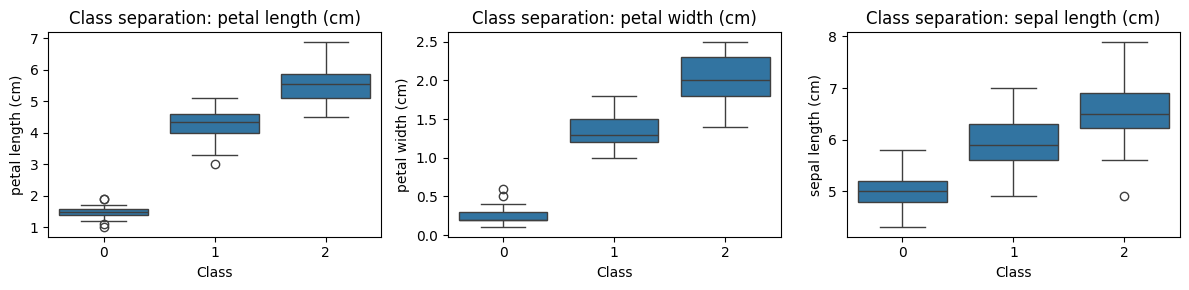

/tmp/ipython-input-8-1945941976.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=y, y=X[feat], palette='Set2')


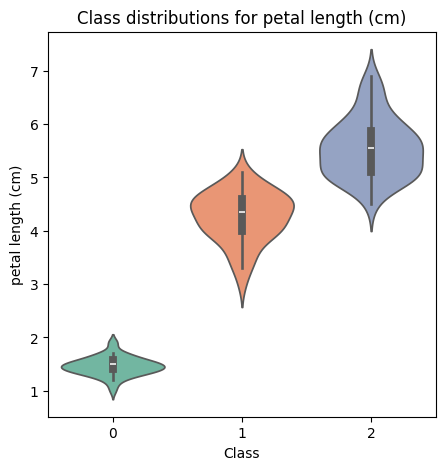

/tmp/ipython-input-8-1945941976.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=y, y=X[feat], palette='Set2')


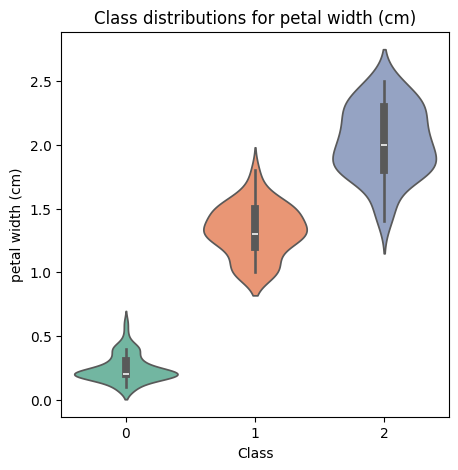

/tmp/ipython-input-8-1945941976.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=y, y=X[feat], palette='Set2')


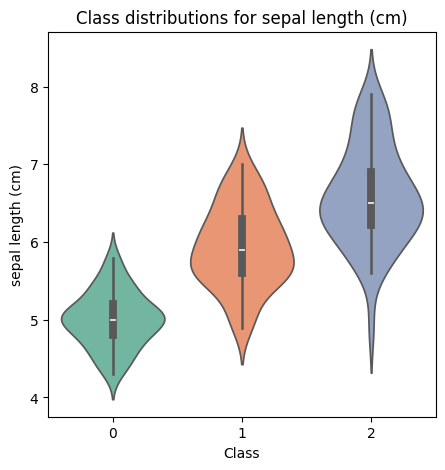

In [8]:
top_features = fs_df['feature'].head(3).tolist()
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
for i, feat in enumerate(top_features):
    sns.boxplot(x=y, y=X[feat], ax=axes[i])
    axes[i].set_title(f"Class separation: {feat}")
    axes[i].set_xlabel('Class')
plt.tight_layout()
plt.show()

# Individual violin plots for better class distribution view
for feat in top_features:
    plt.figure(figsize=(5,5))
    sns.violinplot(x=y, y=X[feat], palette='Set2')
    plt.title(f"Class distributions for {feat}")
    plt.xlabel('Class')
    plt.ylabel(feat)
    plt.show()

In [7]:
print("\n=== Manual Fisher Score Verification ===")
# Verify computation for the top feature
top_feature = fs_df['feature'].iloc[0]
col_data = X[top_feature]
overall_mean = col_data.mean()
classes = np.unique(y)

print(f"Verifying Fisher score for: {top_feature}")
print(f"Overall mean: {overall_mean:.3f}")

between_class_var = 0
within_class_var = 0

for cls in classes:
    class_data = col_data[y == cls]
    class_mean = class_data.mean()
    class_var = class_data.var()
    class_size = len(class_data)

    between_contrib = class_size * (class_mean - overall_mean) ** 2
    within_contrib = class_size * class_var

    between_class_var += between_contrib
    within_class_var += within_contrib

    print(f"Class {cls}: mean={class_mean:.3f}, var={class_var:.3f}, size={class_size}")
    print(f"  Between contribution: {between_contrib:.3f}")
    print(f"  Within contribution: {within_contrib:.3f}")

manual_fisher = between_class_var / within_class_var if within_class_var else 0
computed_fisher = fs_df[fs_df['feature'] == top_feature]['Fisher_score'].iloc[0]

print(f"\nManual Fisher score: {manual_fisher:.6f}")
print(f"Function Fisher score: {computed_fisher:.6f}")
print(f"Match: {abs(manual_fisher - computed_fisher) < 1e-10}")


=== Manual Fisher Score Verification ===
Verifying Fisher score for: petal length (cm)
Overall mean: 3.758
Class 0: mean=1.462, var=0.030, size=50
  Between contribution: 263.581
  Within contribution: 1.508
Class 1: mean=4.260, var=0.221, size=50
  Between contribution: 12.600
  Within contribution: 11.041
Class 2: mean=5.552, var=0.305, size=50
  Between contribution: 160.922
  Within contribution: 15.229

Manual Fisher score: 15.735482
Function Fisher score: 15.735482
Match: True
